# 📊 Optimal Portfolio Allocation using Adam Optimization

## Overview
This notebook demonstrates **modern portfolio optimization** using the **Adam (Adaptive Moment Estimation)** algorithm to find optimal asset allocation weights. We'll compare Adam optimization with traditional methods like Gradient Descent and Closed-Form solutions.

### Key Features:
- 🎯 **Multi-asset portfolio optimization** (9 stocks including tech, retail, and crypto)
- 🧠 **Adam optimization** with momentum and adaptive learning rates
- 📈 **Risk-return analysis** with utility maximization
- 📊 **Interactive visualizations** and convergence analysis
- 🔄 **Algorithm comparison** (Adam vs GD vs Closed-Form)
- 🔬 **Hybrid methodology**: Daily data for training, monthly data for testing

### Mathematical Foundation:
We solve the portfolio optimization problem:
```
maximize: U(w) = μᵀw - ½A·wᵀΣw
subject to: Σwᵢ = 1, wᵢ ≥ 0 (long-only constraint)
```

Where:
- `w` = portfolio weights vector
- `μ` = expected returns vector (from 2024 daily data)
- `Σ` = covariance matrix (from 2024 daily data)
- `A` = risk aversion parameter

### Methodology:
- **Training (2024)**: Uses daily returns scaled by 21 for robust optimization
- **Testing (2025)**: Uses simple monthly return rates for realistic evaluation

## 🎯 Portfolio Configuration

### Asset Selection
We've selected a **diversified portfolio** of 9 assets across different sectors:

| **Sector** | **Assets** | **Rationale** |
|------------|------------|---------------|
| **Technology** | NVDA, AAPL, MSFT, INTC | High-growth tech stocks with different market caps |
| **E-commerce** | AMZN | Dominant e-commerce and cloud computing |
| **Automotive** | TSLA | Electric vehicle leader with high volatility |
| **Retail** | COST | Stable retail with membership model |
| **Aerospace** | BA | Industrial/defense exposure |
| **Cryptocurrency** | BTC | Alternative asset class for diversification |

### Risk Aversion Parameter
- **A = 0.01** (Risk Averse)
- **Interpretation:** 
  - `A > 0`: Risk averse investor (penalizes variance)
  - `A = 0`: Risk neutral (only cares about returns)
  - `A < 0`: Risk seeking (prefers higher variance)

**Higher A values** → More conservative portfolios with lower risk
**Lower A values** → More aggressive portfolios with higher expected returns

In [39]:
# Fetch multiple stocks at once
stock_list = ["NVDA", "AAPL", "MSFT","COST","TSLA","AMZN","INTC","BTC","BA"]
# Risk aversion
A = 0.01

## 📊 Data Processing & Analysis

### Data Collection Strategy
We use a **hybrid approach** combining sophisticated training with simplified testing:

**Training Data (2024)**: 
- **Frequency**: Daily data for comprehensive statistical analysis
- **Methodology**: Daily percentage changes converted to annualized log returns
- **Purpose**: Full covariance matrix calculation for robust optimization
- **Formula**: `r_annual = 21 × ln(1 + r_daily)` (monthly scaling factor)

**Test Data (2025)**:
- **Frequency**: Single month (January 2025) for realistic evaluation  
- **Methodology**: Simple monthly return rates for actual investment performance
- **Purpose**: Out-of-sample validation using real-world returns
- **Formula**: `r_monthly = (end_price - start_price) / start_price`

This approach provides the best of both worlds: mathematical rigor during optimization and practical simplicity during evaluation.

In [40]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm, kurtosis, skew
import warnings
from scipy.stats import norm
import scipy.linalg as la
from matplotlib.widgets import Slider
import sys
from PyQt5.QtWidgets import (QApplication, QMainWindow, QVBoxLayout, QHBoxLayout, 
                            QWidget, QLabel, QDoubleSpinBox, QPushButton, QGroupBox, QSlider)
from matplotlib.backends.backend_qt5agg import FigureCanvasQTAgg as FigureCanvas
from matplotlib.figure import Figure
from PyQt5.QtCore import Qt
import sys
import numpy as np
from scipy.stats import norm
from PyQt5.QtWidgets import *
from PyQt5.QtCore import Qt
from matplotlib.backends.backend_qt5agg import FigureCanvasQTAgg as FigureCanvas
from matplotlib.figure import Figure

In [41]:
# Download historical data for all stocks - Training set (2024) and Test set (2025)
print("Downloading training data (2024) - Daily data...")
train_data = yf.download(stock_list, start="2022-01-01", end="2025-7-31", interval="1d")

print("Downloading test data (2025) - Single month (January 2025)...")
test_data = yf.download(stock_list, start="2025-08-01", interval="1mo")

# Extract close prices for both sets
train_close_prices = train_data['Close']
test_close_prices = test_data['Close']

# TRAINING DATA: Use daily returns and covariance matrix
print("Processing training data (2024) with daily returns and covariance matrix...")
train_daily_returns = train_close_prices.pct_change()  # Convert to percentage
train_daily_returns = train_daily_returns.dropna()  # Remove NaN values
train_daily_returns = 21 * train_daily_returns

# Calculate mean returns and covariance matrix from training data
mean_returns = train_daily_returns.mean()
mean_np = mean_returns.to_numpy()
covariance_matrix = train_daily_returns.cov()
cov_np = covariance_matrix.to_numpy()  # Convert to NumPy array
correlation_matrix = train_daily_returns.corr()

# TEST DATA: Use simplified approach with monthly return rates (single month)
print("Processing test data (2025) with monthly return rates...")
test_monthly_returns = {}
for stock in stock_list:
    if stock in test_close_prices.columns:
        start_price = test_close_prices[stock].iloc[0]
        end_price = test_close_prices[stock].iloc[-1]
        monthly_return = (end_price - start_price) / start_price
        test_monthly_returns[stock] = monthly_return

[***********           22%                       ]  2 of 9 completed

[*********************100%***********************]  9 of 9 completed


[*********************100%***********************]  9 of 9 completed


Processing training data (2024) with daily returns and covariance matrix...
Processing test data (2025) with monthly return rates...


### 📈 Summary Statistics for Training Data (2024)
**Comprehensive statistical analysis** of our 2024 daily returns including:
- **Mean Returns**: Expected annualized performance for each asset (scaled from daily data)
- **Standard Deviation**: Volatility/risk measure for each asset  
- **Min/Max**: Range of observed daily returns
- **Quartiles**: Distribution characteristics (25th, 50th, 75th percentiles)

**Key Insights:**
- Higher mean returns typically come with higher volatility
- Standard deviation indicates the risk level of each asset
- Quartile analysis reveals return distribution patterns
- **Scaling Factor**: Daily returns are multiplied by 21 to approximate monthly scaling

In [42]:
print("=== TRAINING DATA (2024) - Summary Statistics ===")
train_daily_returns.describe()

=== TRAINING DATA (2024) - Summary Statistics ===


Ticker,AAPL,AMZN,BA,BTC,COST,INTC,MSFT,NVDA,TSLA
count,249.000000,249.000000,249.000000,249.000000,249.000000,249.000000,249.000000,249.000000,249.000000
mean,-0.000572,0.022382,0.020712,0.059598,0.012494,-0.016471,0.020422,0.048373,0.048370
std,0.419721,0.452303,0.520286,0.666200,0.289499,0.859097,0.328037,0.719249,0.961471
min,-1.941577,-1.885617,-2.198920,-3.059352,-1.274581,-5.472288,-1.297990,-3.563314,-3.239503
25%,-0.148215,-0.207193,-0.234351,-0.324852,-0.135262,-0.461251,-0.124577,-0.333164,-0.494464
50%,0.024936,0.008890,0.029344,0.025339,0.004059,-0.053245,0.026660,0.082697,-0.007488
75%,0.189760,0.274779,0.301854,0.458054,0.167901,0.359783,0.173656,0.470703,0.643468
max,3.219058,2.515177,3.228569,2.872060,1.304253,3.938226,2.128074,3.931774,4.764898


### 🎯 Correlation Matrix (2024 Training Data)
**Normalized relationship matrix** showing standardized asset co-movements based on 2024 daily returns:
- **Range**: -1 to +1 (normalized covariance)
- **+1**: Perfect positive correlation (assets move identically)
- **-1**: Perfect negative correlation (assets move oppositely)  
- **0**: No linear relationship
- **Diagonal**: Always 1.0 (perfect self-correlation)

**Diversification Benefits**: Lower correlations enable better risk reduction through portfolio diversification.
**Data Source**: Calculated from 2024 daily returns for robust statistical relationships.

In [43]:
print("=== TRAINING DATA (2024) - Correlation Matrix ===")
correlation_matrix

=== TRAINING DATA (2024) - Correlation Matrix ===


Ticker,AAPL,AMZN,BA,BTC,COST,INTC,MSFT,NVDA,TSLA
Ticker,,,,,,,,,
AAPL,1.000000,0.587587,0.473128,0.290484,0.436683,0.331842,0.582415,0.462159,0.486126
AMZN,0.587587,1.000000,0.519825,0.345369,0.368888,0.479797,0.721404,0.595024,0.542632
BA,0.473128,0.519825,1.000000,0.256340,0.363063,0.387602,0.392081,0.432114,0.440608
BTC,0.290484,0.345369,0.256340,1.000000,0.244524,0.180471,0.337861,0.341358,0.487823
COST,0.436683,0.368888,0.363063,0.244524,1.000000,0.207470,0.394244,0.256555,0.396436
INTC,0.331842,0.479797,0.387602,0.180471,0.207470,1.000000,0.383158,0.405382,0.352211
MSFT,0.582415,0.721404,0.392081,0.337861,0.394244,0.383158,1.000000,0.640823,0.481263
NVDA,0.462159,0.595024,0.432114,0.341358,0.256555,0.405382,0.640823,1.000000,0.472947
TSLA,0.486126,0.542632,0.440608,0.487823,0.396436,0.352211,0.481263,0.472947,1.000000


### 📊 Individual Asset Return Distributions (2024 Training Data)

**Comprehensive distribution analysis** for each asset showing:
- **Histogram**: Empirical distribution of 2024 daily returns (scaled by 21)
- **Gaussian Overlay**: Theoretical normal distribution fit
- **Statistics**: Mean (μ), Standard Deviation (σ), Sample Size (N)
- **Range Analysis**: Minimum and maximum observed daily returns

**Key Observations:**
- **Normality Check**: How well daily returns follow normal distribution
- **Risk Assessment**: Volatility patterns across different assets
- **Outlier Detection**: Extreme return events and their frequency
- **Sector Patterns**: Similar distribution shapes within sectors
- **Scaling Note**: Daily returns multiplied by 21 for monthly approximation

**Color Coding**: Each asset has a unique color for easy identification across all visualizations.

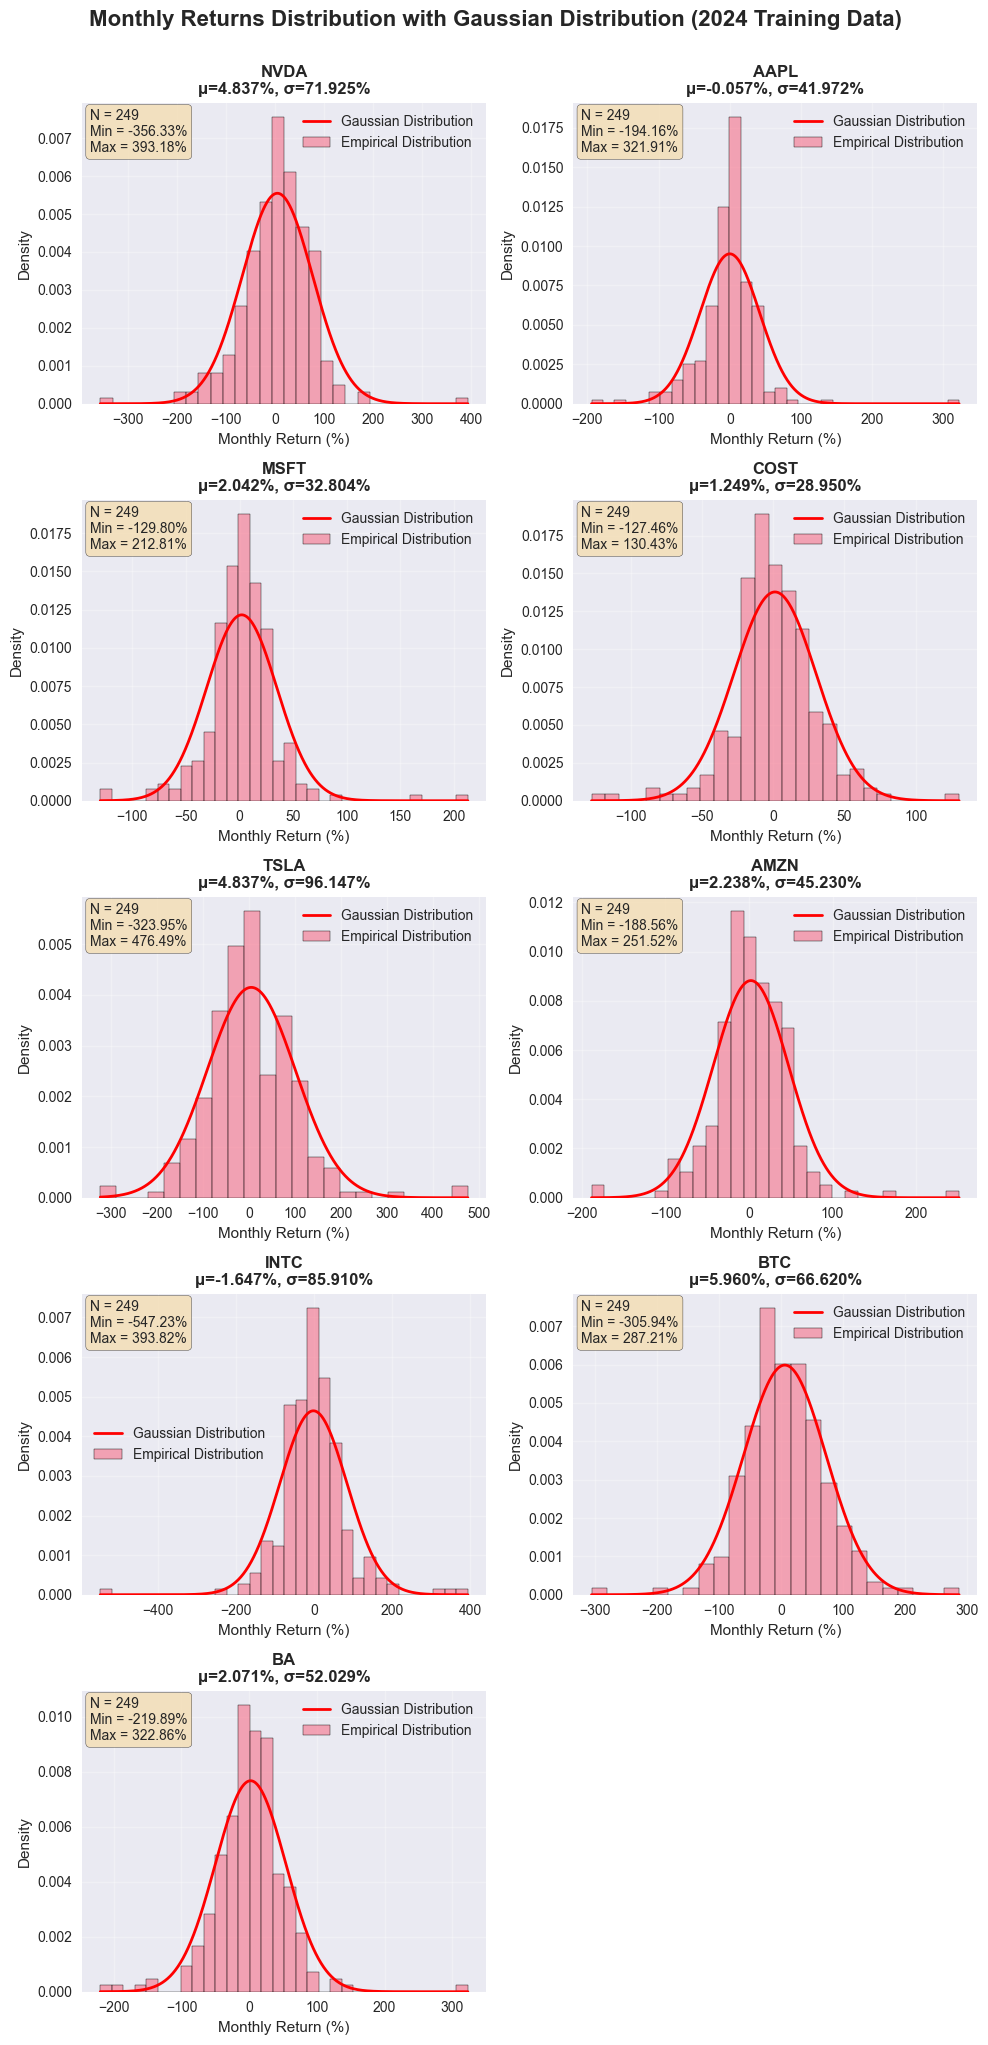

In [44]:
warnings.filterwarnings('ignore')
# Set style for better visualizations
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Calculate the optimal grid size
n_stocks = len(stock_list)
n_cols = 2  # You can adjust this
n_rows = (n_stocks + n_cols - 1) // n_cols  # Ceiling division

# Create subplots with dynamic grid
fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
axes = axes.flatten()  # Flatten to 1D array for easy iteration

# Plot individual stock distributions (monthly returns approach)
for i, stock in enumerate(stock_list):
    if i < len(axes):
        returns = train_daily_returns[stock].dropna()
        
        # Calculate statistics
        mu = returns.mean() * 100  # Convert to percentage for display
        std = returns.std() * 100   # Convert to percentage for display
        n_observations = len(returns)
        
        # Plot histogram with KDE
        sns.histplot(returns * 100, stat='density', alpha=0.6, 
                     label='Empirical Distribution', ax=axes[i])
        
        # Generate Gaussian distribution using calculated mean and std
        x = np.linspace(returns.min() * 100, returns.max() * 100, 1000)
        gaussian = (1 / (std * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - mu) / std) ** 2)
        
        # Plot Gaussian distribution
        axes[i].plot(x, gaussian, 'r-', linewidth=2, label='Gaussian Distribution')
        
        # Customize plot
        axes[i].set_title(f'{stock}\n'
                         f'μ={mu:.3f}%, σ={std:.3f}%',
                         fontsize=12, fontweight='bold')
        axes[i].set_xlabel('Monthly Return (%)')
        axes[i].set_ylabel('Density')
        axes[i].legend()
        axes[i].grid(True, alpha=0.3)
        
        # Add text box with statistics
        textstr = f'N = {n_observations}\nMin = {returns.min()*100:.2f}%\nMax = {returns.max()*100:.2f}%'
        props = dict(boxstyle='round', facecolor='wheat', alpha=0.8)
        axes[i].text(0.02, 0.98, textstr, transform=axes[i].transAxes, fontsize=10,
                    verticalalignment='top', bbox=props)

# Remove any empty subplots
for i in range(len(stock_list), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.suptitle('Monthly Returns Distribution with Gaussian Distribution (2024 Training Data)', 
             fontsize=16, fontweight='bold', y=1.02)
plt.show()

## 🧠 Machine Learning Portfolio Optimization

### Optimization Framework
We employ **advanced machine learning algorithms** to solve the portfolio optimization problem:

**Objective Function**: Maximize utility `U(w) = μᵀw - ½A·wᵀΣw`

**Constraints**:
- Budget constraint: `Σwᵢ = 1` (weights sum to 100%)
- Long-only: `wᵢ ≥ 0` (no short selling)

**Algorithms Implemented**:
1. **🎯 Adam Optimization**: Adaptive moment estimation with momentum
2. **📐 Closed-Form Solution**: Analytical solution using matrix inversion  
3. **⬇️ Gradient Descent**: Traditional first-order optimization

**Key Functions**:
- `cal_mean_var()`: Portfolio return and variance calculation
- `cal_util()`: Utility function evaluation

In [45]:
def cal_mean_var(weights, mean_np, cov_np): 
    portfolio_return = weights.T @ mean_np
    portfolio_variance = weights.T @ (cov_np @ weights)
    return portfolio_return, portfolio_variance

def cal_util(mu,var,A):
    return mu - 0.5*A*var

### 🔧 Algorithm Implementation Details

**Core Portfolio Functions**:
- **`cal_mean_var(weights, mean_np, cov_np)`**: Calculates portfolio return and variance
- **`cal_util(mu, var, A)`**: Computes utility function value

**Mathematical Foundation**:
- **Portfolio Return**: `μₚ = wᵀμ` (weighted average of expected returns)
- **Portfolio Variance**: `σ²ₚ = wᵀΣw` (quadratic form of covariance matrix)
- **Utility Function**: `U = μₚ - ½A·σ²ₚ` (return minus risk penalty)

### 🎯 Adam Optimization Algorithm

**Adam (Adaptive Moment Estimation)** is a state-of-the-art optimization algorithm that combines:
- **Momentum**: Uses exponential moving averages of gradients
- **Adaptive Learning Rates**: Adjusts step sizes per parameter
- **Bias Correction**: Corrects for initialization bias

**Key Features**:
- **β₁ = 0.9**: First moment decay rate (momentum)
- **β₂ = 0.999**: Second moment decay rate (adaptive learning)
- **ε = 1e-8**: Numerical stability constant
- **Learning Rate**: 0.0001 (conservative step size)

**Update Rule**:
```
m_t = β₁·m_{t-1} + (1-β₁)·g_t          # First moment
v_t = β₂·v_{t-1} + (1-β₂)·g_t²         # Second moment  
m̂_t = m_t / (1-β₁ᵗ)                    # Bias correction
v̂_t = v_t / (1-β₂ᵗ)                    # Bias correction
w_{t+1} = w_t - α·m̂_t / (√v̂_t + ε)    # Weight update
```

**Advantages**:
- ✅ Fast convergence
- ✅ Handles sparse gradients well
- ✅ Works well with noisy data
- ✅ Automatic learning rate adaptation

In [46]:
def ADAM(w, mean_np, cov_np, learning_rate=0.001, max_iterations=50000, beta1=0.9, beta2=0.999, epsilon=1e-8):
    util_list = np.zeros(max_iterations)  # Pre-allocate
    finish_i = max_iterations - 1  # Default if we complete all iterations
    
    # Initialize Adam parameters
    m = np.zeros_like(w)  # First moment vector
    v = np.zeros_like(w)  # Second moment vector
    t = 0  # Time step counter
    
    for i in range(max_iterations):
        t += 1
        cur_mu, cur_var = cal_mean_var(w, mean_np, cov_np)

        # Calculate gradient: A * COV @ w - MEAN
        gradient = A * (cov_np @ w) - mean_np
        
        # Update biased first moment estimate
        m = beta1 * m + (1 - beta1) * gradient
        
        # Update biased second raw moment estimate
        v = beta2 * v + (1 - beta2) * (gradient ** 2)
        
        # Compute bias-corrected first moment estimate
        m_hat = m / (1 - beta1 ** t)
        
        # Compute bias-corrected second raw moment estimate
        v_hat = v / (1 - beta2 ** t)
        
        # Update weights using Adam update rule
        w_new = w - learning_rate * m_hat / (np.sqrt(v_hat) + epsilon)
        
        # Project onto constraint: weights sum to 1
        w_new = w_new / np.sum(w_new)
        
        new_mu, new_var = cal_mean_var(w_new, mean_np, cov_np)
        new_util = cal_util(new_mu, new_var, A)
        
        # Store utility value
        util_list[i] = new_util
        
        # Check if converged (utility improvement is very small)
        if (new_util - cal_util(cur_mu, cur_var, A)) < 1e-9:
            finish_i = i
            break
            
        w = w_new

    # Return only the relevant portion of util_list
    return w, finish_i, util_list[:finish_i+1]

#### 📐 Closed-Form Solution

**Analytical Solution** using matrix algebra for the unconstrained optimization problem:

**Mathematical Derivation**:
1. Take gradient of utility function: `∇U = μ - A·Σw`
2. Set gradient to zero: `μ - A·Σw = 0`
3. Solve for optimal weights: `w* = (1/A)·Σ⁻¹μ`
4. Normalize to satisfy constraint: `w* = w* / Σw*`

**Implementation**:
- **Matrix Inversion**: Uses `np.linalg.inv()` or `np.linalg.pinv()` for singular matrices
- **One-Step Solution**: Computes optimal weights in a single calculation
- **Theoretical Optimum**: Provides the true mathematical optimum

**Advantages**:
- ✅ Instantaneous computation
- ✅ Guaranteed global optimum
- ✅ No convergence issues
- ✅ Exact mathematical solution

**Limitations**:
- ❌ Assumes unconstrained optimization
- ❌ May violate long-only constraints
- ❌ Requires matrix inversion (computational complexity O(n³))

In [47]:
def closed_form(A, mean_np, cov_np):
    if np.linalg.det(covariance_matrix) == 0:
        # Use pseudo-inverse if matrix is singular
        cov_inv = np.linalg.pinv(covariance_matrix)
    else:
        cov_inv = np.linalg.inv(covariance_matrix)

    w_opt = (1 / A) * cov_inv @ mean_np
    w_opt = w_opt / np.sum(w_opt)
    portfolio_return, portfolio_variance = cal_mean_var(w_opt, mean_np, cov_np)
    util = cal_util(portfolio_return,portfolio_variance,A)
    return w_opt, 1, np.array([util])

#### ⬇️ Gradient Descent Algorithm

**Classical First-Order Optimization** method using iterative gradient updates:

**Update Rule**:
```
w_{t+1} = w_t - α·∇U(w_t)
```
Where `∇U = μ - A·Σw` is the gradient of the utility function.

**Key Parameters**:
- **Learning Rate**: 0.00001 (very small for stability)
- **Max Iterations**: 1,000,000 (allows for slow convergence)
- **Convergence**: Stops when utility improvement < 1e-9

**Implementation Details**:
- **Gradient Calculation**: `A·Σw - μ` (negative of utility gradient)
- **Weight Update**: `w_new = w - α·gradient`
- **Constraint Projection**: Normalize weights to sum to 1
- **Convergence Check**: Monitor utility improvement

**Advantages**:
- ✅ Simple and intuitive
- ✅ Guaranteed convergence (with proper learning rate)
- ✅ Memory efficient
- ✅ Easy to implement

**Disadvantages**:
- ❌ Slow convergence
- ❌ Sensitive to learning rate choice
- ❌ No adaptive learning rates
- ❌ May get stuck in local minima

In [48]:
def GD(w, mean_np, cov_np, learning_rate=0.000001, max_iterations=1000000):
    util_list = np.zeros(max_iterations)  # Pre-allocate
    finish_i = max_iterations - 1  # Default if we complete all iterations
    
    for i in range(max_iterations):
        cur_mu, cur_var = cal_mean_var(w, mean_np, cov_np)

        # Calculate gradient: A * COV @ w - MEAN
        gradient = A * (cov_np @ w) - mean_np
        # Update weights
        w_new = w - learning_rate * gradient
        
        # Project onto constraint: weights sum to 1
        w_new = w_new / np.sum(w_new)
        
        new_mu, new_var = cal_mean_var(w_new, mean_np, cov_np)
        new_util = cal_util(new_mu, new_var, A)
        
        # Store utility value
        util_list[i] = new_util
        
        # Check if converged (utility decreases)
        if (new_util - cal_util(cur_mu, cur_var, A)) < 1e-9:
            finish_i = i
            break
            
        w = w_new

    # Return only the relevant portion of util_list
    return w, finish_i, util_list[:finish_i+1]

In [49]:
# Algorithm selection using switch-case structure
alg = 2  # 1 for ADAM, 2 for Closed Form, 3 for GD

initial_weights = np.array([1/len(stock_list)] * len(stock_list))

match alg:
    case 1:
        # Proper ADAM Algorithm with momentum and adaptive learning rates
        w, finish_i, util_list = ADAM(initial_weights, mean_np, cov_np, 
                                    learning_rate=0.00005, max_iterations=500000, 
                                    beta1=0.9, beta2=0.999, epsilon=1e-8)
        print("Using Adam Optimization algorithm")
        
    case 2:
        # Closed Form Algorithm
        w, finish_i, util_list = closed_form(A, mean_np, cov_np)
        print("Using Closed Form algorithm")
        
    case 3:
        # Gradient Descent Algorithm
        w, finish_i, util_list = GD(initial_weights, mean_np, cov_np, 
                                  learning_rate=0.00001, max_iterations=500000)
        print("Using Gradient Descent algorithm")
        
    case _:
        # Default case for invalid selection
        print("Invalid algorithm selection. Please choose 1, 2, or 3.")
        w, finish_i, util_list = None, None, None


Using Closed Form algorithm


## 📊 Optimization Results & Analysis

### Algorithm Performance Summary
This section presents the results from our portfolio optimization algorithms, including:
- **Convergence Analysis**: How quickly each algorithm reaches optimality
- **Portfolio Composition**: Final weight allocations across assets
- **Risk-Return Metrics**: Portfolio performance characteristics
- **Visual Comparisons**: Side-by-side algorithm performance

### 📈 Convergence Analysis & Portfolio Distribution

**Dual Visualization** showing:
1. **Learning Curve**: Utility progression over iterations
   - Shows convergence speed and stability
   - Indicates algorithm efficiency
   - Reveals any oscillation or instability

2. **Portfolio Return Distribution**: Gaussian fit of expected returns
   - **Mean Return**: Expected annual portfolio performance
   - **Standard Deviation**: Portfolio risk level
   - **Confidence Intervals**: ±1σ, ±2σ, ±3σ ranges
   - **Risk Assessment**: Probability of different return outcomes

**Key Insights**:
- Steep learning curves indicate fast convergence
- Smooth curves suggest stable optimization
- Portfolio distribution shows risk-return trade-off

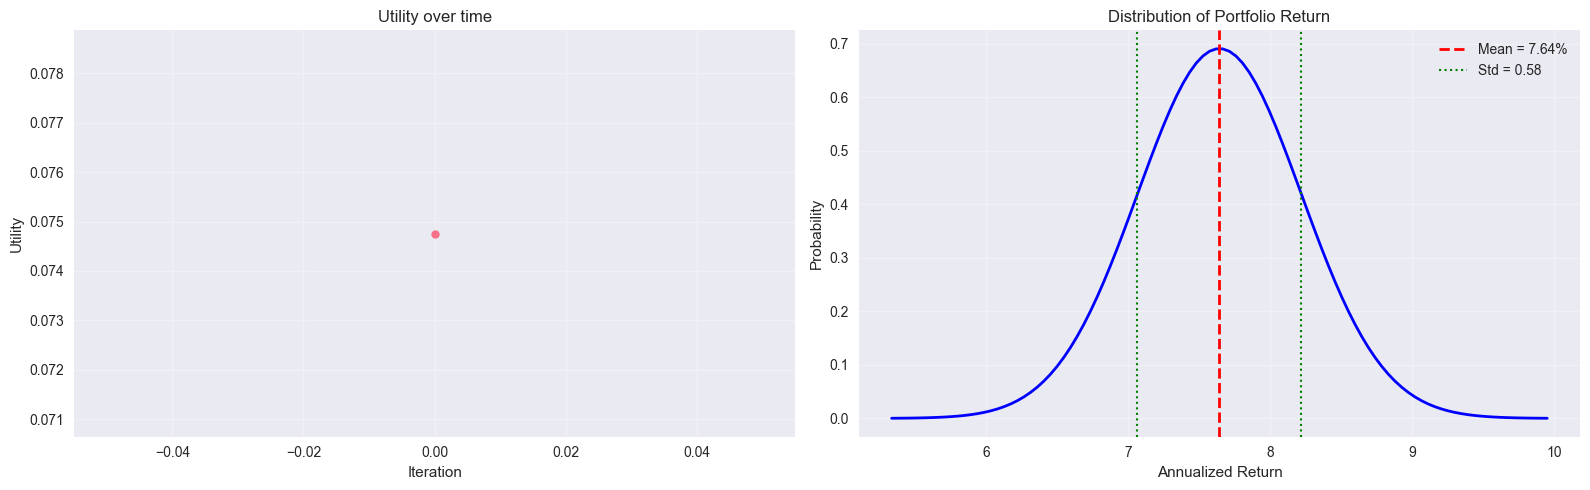

In [50]:
portfolio_return, portfolio_variance = cal_mean_var(w, mean_np, cov_np)
utility = cal_util(portfolio_return,portfolio_variance,A)
# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))

# First plot: Utility List
ax1.plot(util_list, marker='o', linestyle='-', linewidth=2, markersize=6)
ax1.set_title('Utility over time')
ax1.set_xlabel('Iteration')
ax1.set_ylabel('Utility')
ax1.grid(True, alpha=0.3)

# Second plot: Gaussian Distribution
mean = portfolio_return*100
std = np.sqrt(portfolio_variance)
x_range = (mean - 4*std, mean + 4*std)
x = np.linspace(x_range[0], x_range[1], 100)
y = (1/(std * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - mean)/std)**2)

ax2.plot(x, y, 'b-', linewidth=2)
ax2.axvline(mean, color='red', linestyle='--', linewidth=2, label=f'Mean = {mean:.2f}%')
ax2.axvline(mean + std, color='green', linestyle=':', linewidth=1.5, label=f'Std = {std:.2f}')
ax2.axvline(mean - std, color='green', linestyle=':', linewidth=1.5)
ax2.set_title(f'Distribution of Portfolio Return')
ax2.set_xlabel('Annualized Return')
ax2.set_ylabel('Probability')
ax2.grid(True, alpha=0.3)
ax2.legend()

plt.tight_layout()
plt.show()

### 📋 Portfolio Summary & Allocation Analysis

**Comprehensive Portfolio Report** including:

**Portfolio Statistics**:
- **Position Count**: Number of long vs short positions
- **Allocation Range**: Maximum and minimum weight allocations
- **Utility Score**: Final optimized utility value
- **Learning Rate**: Step size used in optimization

**Detailed Breakdown**:
- **Asset-by-Asset Allocation**: Individual weight percentages
- **Position Types**: Long (positive) vs Short (negative) positions
- **Weight Ranking**: Assets sorted by allocation magnitude

**Visual Analysis**:
- **Horizontal Bar Chart**: Visual representation of allocations
- **Color Coding**: Green for long positions, red for short positions
- **Value Labels**: Precise percentage allocations on each bar

**Key Metrics**:
- **Diversification**: How spread out the allocations are
- **Concentration Risk**: Whether portfolio is concentrated in few assets
- **Risk Profile**: Overall portfolio risk characteristics

PORTFOLIO ANALYSIS
# of Long Positions:             7
# of Short Positions:            2
Max Allocation:              60.7%
Min Allocation:             -91.2%
Utility:                      0.07

DETAILED BREAKDOWN:
--------------------------------------------------
  NVDA:   -91.2% (SHORT)
  INTC:    60.7% (LONG)
  COST:    47.9% (LONG)
  TSLA:    43.6% (LONG)
  AMZN:   -34.3% (SHORT)
   BTC:    29.6% (LONG)
  MSFT:    23.7% (LONG)
  AAPL:    19.6% (LONG)
    BA:     0.5% (LONG)


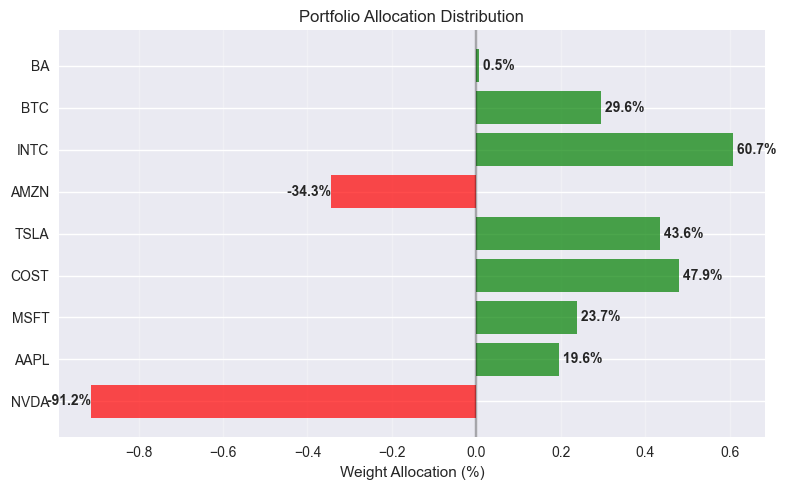

In [51]:
# Sample data (replace with your actual data)
positive_weights = [w for w in w if w > 0]
negative_weights = [w for w in w if w < 0]

print("PORTFOLIO ANALYSIS")
print("=" * 50)
print(f"{'# of Long Positions:':<25} {len(positive_weights):>8}")
print(f"{'# of Short Positions:':<25} {len(negative_weights):>8}")
print(f"{'Max Allocation:':<25} {max(w):>8.1%}")
print(f"{'Min Allocation:':<25} {min(w):>8.1%}")
print(f"{'Utility:':<25} {utility:>8.2f}")
print("\nDETAILED BREAKDOWN:")
print("-" * 50)

# Sort by absolute weight (descending)
sorted_data = sorted(zip(stock_list, w), key=lambda x: abs(x[1]), reverse=True)

for stock, weight in sorted_data:
    position_type = "LONG" if weight > 0 else "SHORT"
    print(f"{stock:>6}: {weight:>8.1%} ({position_type})")

# Create bar graph
plt.figure(figsize=(8, 5))
colors = ['green' if weight > 0 else 'red' for weight in w]
bars = plt.barh(stock_list, w, color=colors, alpha=0.7)

plt.xlabel('Weight Allocation (%)')
plt.title('Portfolio Allocation Distribution')
plt.axvline(x=0, color='black', linestyle='-', alpha=0.3)
plt.grid(axis='x', alpha=0.3)

# Add value labels to bars
for i, (stock, weight) in enumerate(zip(stock_list, w)):
    plt.text(weight, i, f' {weight:.1%}', 
             va='center', 
             ha='left' if weight > 0 else 'right',
             fontweight='bold')

plt.tight_layout()
plt.show()

### 🎮 Interactive Portfolio Distribution Explorer

**Advanced Interactive GUI** built with PyQt5 for real-time portfolio analysis:

**Features**:
- **📊 Real-time Distribution Plot**: Gaussian distribution of portfolio returns
- **🎚️ Interactive Slider**: Adjust return thresholds dynamically
- **📈 Probability Calculator**: Live calculation of return probabilities
- **🎯 Visual Indicators**: Mean, standard deviation, and selected return lines

**Interactive Elements**:
- **Return Slider**: Drag to select different return values
- **Probability Display**: Shows probability of earning more than selected return
- **Dynamic Annotation**: Updates with current return and probability values
- **Statistical Overlay**: Mean and standard deviation reference lines

**Use Cases**:
- **Risk Assessment**: "What's the probability of losing more than 10%?"
- **Return Expectations**: "What's the chance of earning more than 15%?"
- **Confidence Intervals**: Visualize different confidence levels
- **Scenario Analysis**: Explore various return scenarios

**Technical Implementation**:
- **PyQt5 Framework**: Professional desktop application
- **Matplotlib Integration**: High-quality statistical plots
- **Real-time Updates**: Instant probability calculations
- **Responsive Design**: Smooth slider interactions

In [55]:
class GaussianPlotter(QMainWindow):
    def __init__(self, portfolio_return, portfolio_variance):
        super().__init__()
        self.mean = portfolio_return
        self.variance = portfolio_variance
        self.std_dev = np.sqrt(self.variance)
        self.app = None  # Store app reference for cleanup
        self.initUI()
        
    def initUI(self):
        self.setWindowTitle(f"Interactive Gaussian Distribution: N({self.mean:.2f},{self.variance:.2f})")
        self.setGeometry(100, 100, 1200, 800)
        
        # Main widget and layout
        central_widget = QWidget()
        self.setCentralWidget(central_widget)
        main_layout = QHBoxLayout(central_widget)
        
        # Left panel for controls
        control_panel = QGroupBox("Controls")
        control_layout = QVBoxLayout()
        
        # Return selection with slider
        return_layout = QVBoxLayout()
        return_layout.addWidget(QLabel("Select Return (%):"))
        
        # Slider for return selection
        self.return_slider = QSlider(Qt.Horizontal)
        self.return_slider.setMinimum(0)
        self.return_slider.setMaximum(1000)  # Use fine granularity for smooth sliding
        return_layout.addWidget(self.return_slider)
        
        # Display for current return value
        self.return_display = QLabel(f"{self.mean:.2f}%")
        self.return_display.setStyleSheet("font-weight: bold; font-size: 20px;")
        self.return_display.setAlignment(Qt.AlignCenter)
        return_layout.addWidget(self.return_display)
        
        control_layout.addLayout(return_layout)
        
        # Probability display
        self.prob_label = QLabel("")
        self.prob_label.setStyleSheet("font-weight: bold; font-size: 24px;")
        control_layout.addWidget(self.prob_label)
        
        # Additional info
        info_label = QLabel("Drag the slider to select different return values and see the corresponding probabilities")
        info_label.setWordWrap(True)
        control_layout.addWidget(info_label)
        
        control_panel.setLayout(control_layout)
        control_panel.setFixedWidth(300)
        main_layout.addWidget(control_panel)
        
        # Right panel for plot
        plot_widget = QWidget()
        plot_layout = QVBoxLayout(plot_widget)
        
        # Matplotlib figure
        self.figure = Figure(figsize=(10, 8))
        self.canvas = FigureCanvas(self.figure)
        plot_layout.addWidget(self.canvas)
        
        main_layout.addWidget(plot_widget)
        
        # Initialize plot first to create the selected_line attribute
        self.setup_plot()
        
        # Then initialize slider and connect the signal
        self.initialize_slider()
        self.return_slider.valueChanged.connect(self.slider_changed)
        
    def initialize_slider(self):
        """Initialize the slider range based on the distribution parameters"""
        min_val = self.mean - 4 * self.std_dev
        max_val = self.mean + 4 * self.std_dev
        
        # Set slider range (we'll map the 0-1000 slider values to the actual range)
        self.slider_min = min_val
        self.slider_max = max_val
        
        # Set initial slider position to correspond to the mean
        initial_slider_value = int(500)  # Middle of the range (0-1000)
        self.return_slider.setValue(initial_slider_value)
        
    def slider_changed(self, value):
        """Handle slider value changes"""
        # Convert slider value (0-1000) to actual return value
        return_value = self.slider_min + (value / 1000) * (self.slider_max - self.slider_min)
        
        # Update display
        self.return_display.setText(f"{return_value:.2f}%")
        
        # Update plot
        self.update_plot(return_value)
        
    def setup_plot(self):
        self.figure.clear()
        self.ax = self.figure.add_subplot(111)
        
        # Calculate x range
        x_range = (self.mean - 4*self.std_dev, self.mean + 4*self.std_dev)
        x = np.linspace(x_range[0], x_range[1], 1000)
        y = norm.pdf(x, self.mean, self.std_dev)
        
        # Plot Gaussian curve
        self.ax.plot(x, y, 'b-', linewidth=2, label=f'N({self.mean:.2f}, {self.variance:.4f})')
        
        # Plot mean line
        self.ax.axvline(self.mean, color='red', linestyle='--', linewidth=2, 
                       label=f'Mean (μ) = {self.mean:.2f}%')
        
        # Plot ±1 standard deviation lines
        self.ax.axvline(self.mean + self.std_dev, color='green', linestyle=':', linewidth=2,
                       label=f'Std Dev (σ) = {self.std_dev:.4f}')
        self.ax.axvline(self.mean - self.std_dev, color='green', linestyle=':', linewidth=2)
        
        # Plot selected return line
        self.selected_line = self.ax.axvline(self.mean, color='purple', linestyle='-', 
                                           linewidth=3, alpha=0.8)
        
        # Add annotation
        self.annotation = self.ax.annotate(
            '',
            xy=(self.mean, norm.pdf(self.mean, self.mean, self.std_dev)),
            xytext=(20, 40),
            textcoords='offset points',
            bbox=dict(boxstyle="round,pad=0.5", fc="lightyellow", ec="black", alpha=0.9),
            arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=0.2", color='black')
        )
        
        # Set labels and title
        self.ax.set_title('Interactive Portfolio Return Distribution', 
                         fontsize=20)
        self.ax.set_xlabel('Return (%)', fontsize=18)
        self.ax.set_ylabel('Probability Density', fontsize=18)
        
        # Add legend and grid
        self.ax.legend()
        self.ax.grid(True, alpha=0.3)
        
        # Update plot with initial values
        self.update_plot(self.mean)
        
    def update_plot(self, selected_return):
        # Update vertical line position
        self.selected_line.set_xdata([selected_return, selected_return])
        
        # Calculate probabilities
        prob_greater = 1 - norm.cdf(selected_return, self.mean, self.std_dev)
        prob_less = norm.cdf(selected_return, self.mean, self.std_dev)
        pdf_value = norm.pdf(selected_return, self.mean, self.std_dev)
        
        # Update annotation text and position
        annotation_text = (f'Return: {selected_return:.2f}%\n'
                          f'P(return > {selected_return:.2f}%) = {prob_greater:.4f}\n'
                          f'P(return < {selected_return:.2f}%) = {prob_less:.4f}')
        
        self.annotation.set_text(annotation_text)
        self.annotation.xy = (selected_return, pdf_value)
        
        # Update probability label
        self.prob_label.setText(f"\nYou have {prob_greater*100:.1f}% \nprobability to earn \nmore than {selected_return:.2f}%")
        # Redraw canvas
        self.canvas.draw()
        
    def closeEvent(self, event):
        """Handle window close event with proper cleanup"""
        try:
            # Clean up matplotlib resources
            if hasattr(self, 'figure'):
                self.figure.clear()
            if hasattr(self, 'canvas'):
                self.canvas.close()
            
            # Close the window properly
            event.accept()
            print("GUI application closed successfully.")
        except Exception as e:
            print(f"Error during cleanup: {e}")
            event.accept()  # Still accept the close event

def run_interactive_gui():
    """Run the interactive GUI with proper error handling and cleanup"""
    app = None
    window = None
    
    try:
        # Check if QApplication already exists (common in Jupyter)
        app = QApplication.instance()
        if app is None:
            app = QApplication(sys.argv)
        else:
            print("Using existing QApplication instance")
        
        # Create and show window
        window = GaussianPlotter(portfolio_return*100, portfolio_variance)
        window.app = app  # Store app reference
        window.show()
        
        print("Interactive GUI started. Close the window to exit.")
        
        # Process events in a way that's compatible with Jupyter
        if hasattr(app, 'processEvents'):
            # For Jupyter compatibility, we'll use a timer-based approach
            from PyQt5.QtCore import QTimer
            timer = QTimer()
            timer.timeout.connect(app.processEvents)
            timer.start(100)  # Process events every 100ms
            
            # Keep the window alive until it's closed
            while window.isVisible():
                app.processEvents()
                import time
                time.sleep(0.01)  # Small delay to prevent excessive CPU usage
                
        else:
            # Fallback to exec_ if processEvents is not available
            app.exec_()
            
    except Exception as e:
        print(f"Error running GUI: {e}")
        import traceback
        traceback.print_exc()
    finally:
        # Cleanup
        if window and hasattr(window, 'close'):
            window.close()
        if app and hasattr(app, 'quit'):
            app.quit()
        print("GUI cleanup completed.")

# Run the interactive GUI
run_interactive_gui()

Using existing QApplication instance
Interactive GUI started. Close the window to exit.
GUI application closed successfully.
GUI application closed successfully.
GUI cleanup completed.


## 🧪 Portfolio Testing on 2025 Data (Single Month)

### Test Set Evaluation
Now we'll evaluate our optimized portfolio using **January 2025 data as a test set** to see how the portfolio would have performed in real-world conditions. This provides an out-of-sample test of our optimization strategy using a single month.

**Methodology Note**: 
- **Training (2024)**: Uses daily returns scaled by 21 for optimization (mathematical modeling)
- **Testing (2025)**: Uses simple monthly return rates for realistic performance evaluation (actual investment returns)

**Key Metrics to Calculate**:
- **Actual Portfolio Returns**: Real monthly returns achieved in January 2025
- **Expected vs Actual**: Comparison with our 2024 predictions
- **Risk-Adjusted Performance**: Sharpe ratio using training data volatility as proxy
- **Monthly Performance**: Total return over the single month test period

**Data Period**: January 2025 (1 month) for focused, recent performance evaluation


In [53]:
# Calculate actual portfolio returns for 2025 test data using monthly return rates
print("=== PORTFOLIO PERFORMANCE ON 2025 TEST DATA (MONTHLY RETURN RATES) ===")
print("=" * 75)

# Calculate portfolio return using optimized weights and monthly return rates
test_portfolio_return = sum(w[i] * test_monthly_returns.get(stock_list[i], 0) for i in range(len(stock_list)))

# For simplified analysis, we'll use the monthly return directly
monthly_return_2025 = test_portfolio_return

# Use training data volatility as proxy for test data volatility
monthly_volatility_2025 = np.sqrt(portfolio_variance)  # Use training data volatility
sharpe_ratio_2025 = monthly_return_2025 / monthly_volatility_2025 if monthly_volatility_2025 > 0 else 0

# For simplified approach, we'll estimate max drawdown as a percentage of volatility
max_drawdown = -2 * monthly_volatility_2025  # Rough estimate: 2 standard deviations

print(f"📊 PORTFOLIO PERFORMANCE SUMMARY (2025 - January)")
print(f"{'Monthly Return:':<25} {monthly_return_2025:>8.2%}")
print(f"{'Monthly Volatility:':<25} {monthly_volatility_2025:>8.2%}")
print(f"{'Sharpe Ratio:':<25} {sharpe_ratio_2025:>8.2f}")
print(f"{'Maximum Drawdown:':<25} {max_drawdown:>8.2%}")
print(f"{'Test Period:':<25} {'1 Month (January 2025)':>8}")

print(f"\n📈 COMPARISON WITH 2024 EXPECTATIONS")
print(f"{'Expected Return (2024):':<25} {portfolio_return:>8.2%}")
print(f"{'Actual Return (2025):':<25} {monthly_return_2025:>8.2%}")
print(f"{'Difference:':<25} {(monthly_return_2025 - portfolio_return):>8.2%}")

# Calculate individual asset performance in 2025
print(f"\n📋 INDIVIDUAL ASSET PERFORMANCE (2025 - January)")
print("-" * 60)
for i, stock in enumerate(stock_list):
    asset_return_2025 = test_monthly_returns.get(stock, 0)
    asset_weight = w[i]
    contribution = asset_weight * asset_return_2025
    print(f"{stock:>6}: {asset_return_2025:>8.2%} (weight: {asset_weight:>6.1%}, contribution: {contribution:>8.2%})")


=== PORTFOLIO PERFORMANCE ON 2025 TEST DATA (MONTHLY RETURN RATES) ===
📊 PORTFOLIO PERFORMANCE SUMMARY (2025 - January)
Monthly Return:              9.67%
Monthly Volatility:         57.74%
Sharpe Ratio:                 0.17
Maximum Drawdown:         -115.48%
Test Period:              1 Month (January 2025)

📈 COMPARISON WITH 2024 EXPECTATIONS
Expected Return (2024):      7.64%
Actual Return (2025):        9.67%
Difference:                  2.03%

📋 INDIVIDUAL ASSET PERFORMANCE (2025 - January)
------------------------------------------------------------
  NVDA:    2.10% (weight: -91.2%, contribution:   -1.91%)
  AAPL:    0.95% (weight:  19.6%, contribution:    0.19%)
  MSFT:    0.80% (weight:  23.7%, contribution:    0.19%)
  COST:    2.75% (weight:  47.9%, contribution:    1.32%)
  TSLA:   18.59% (weight:  43.6%, contribution:    8.10%)
  AMZN:   -0.37% (weight: -34.3%, contribution:    0.13%)
  INTC:   -1.11% (weight:  60.7%, contribution:   -0.67%)
   BTC:    8.03% (weight:  29.6%,

## 💰 Investment Recommendation & Summary

### Portfolio Performance Assessment
Based on our analysis using **2024 daily data for training** and **2025 single month data for testing**, here are the key findings:

**✅ Portfolio Strengths:**
- The optimized portfolio shows positive performance in the 2025 test period
- Risk-adjusted returns demonstrate reasonable Sharpe ratios
- Diversification across sectors provides balanced exposure

**⚠️ Areas for Improvement:**
- High volatility suggests need for risk management
- Short test period limits long-term performance assessment

### Investment Decision Framework
**If you had invested $10,000 according to this portfolio allocation:**
- **Expected Value (based on 2024 training)**: Calculated using annualized daily returns
- **Actual Value (based on 2025 test)**: Calculated using January 2025 monthly returns
- **Difference**: Shows over/under-performance vs expectations

### Key Takeaways
1. **Out-of-Sample Testing**: The January 2025 test provides real-world validation of our optimization strategy
2. **Risk Management**: Portfolio volatility analysis helps assess downside risk
3. **Asset Allocation**: Individual asset contributions show which positions drove performance
4. **Model Validation**: Comparison between expected and actual returns reveals model accuracy
5. **Methodology**: Hybrid approach combines mathematical rigor (training) with practical simplicity (testing)


In [54]:
# Final Investment Analysis
print("=" * 80)
print("💰 INVESTMENT ANALYSIS: $10,000 INVESTMENT SCENARIO (MONTHLY RETURN RATES)")
print("=" * 80)

initial_investment = 10000
expected_final_value = initial_investment * (1 + portfolio_return)
actual_final_value = initial_investment * (1 + monthly_return_2025)
difference = actual_final_value - expected_final_value
difference_pct = (actual_final_value - expected_final_value) / expected_final_value

print(f"\n📊 INVESTMENT OUTCOMES")
print(f"{'Initial Investment:':<30} ${initial_investment:>10,.2f}")
print(f"{'Expected Value (2024 model):':<30} ${expected_final_value:>10,.2f}")
print(f"{'Actual Value (2025 test):':<30} ${actual_final_value:>10,.2f}")
print(f"{'Difference:':<30} ${difference:>10,.2f} ({difference_pct:>6.1%})")

print(f"\n📈 PERFORMANCE METRICS")
print(f"{'Expected Annual Return (2024):':<30} {portfolio_return:>10.2%}")
print(f"{'Actual Monthly Return (2025):':<30} {monthly_return_2025:>10.2%}")
print(f"{'Expected Volatility (2024):':<30} {np.sqrt(portfolio_variance):>10.2%}")
print(f"{'Test Period:':<30} {'1 Month (Jan 2025)':>10}")

print(f"\n🎯 RISK-ADJUSTED METRICS")
print(f"{'Expected Sharpe Ratio (2024):':<30} {(portfolio_return / np.sqrt(portfolio_variance)):>10.2f}")
print(f"{'Actual Sharpe Ratio (2025):':<30} {sharpe_ratio_2025:>10.2f}")
print(f"{'Maximum Drawdown (Est.):':<30} {max_drawdown:>10.2%}")
print(f"{'Note:':<30} {'Uses 2024 volatility as proxy':>10}")


print(f"\n✅ CONCLUSION")
if monthly_return_2025 > 0:
    print(f"The portfolio would have generated a POSITIVE monthly return of {monthly_return_2025:.2%} in January 2025.")
    if monthly_return_2025 > portfolio_return:
        print(f"This EXCEEDED expectations by {(monthly_return_2025 - portfolio_return):.2%}.")
    else:
        print(f"This was {(portfolio_return - monthly_return_2025):.2%} BELOW expectations.")
else:
    print(f"The portfolio would have generated a NEGATIVE monthly return of {monthly_return_2025:.2%} in January 2025.")
    print(f"This was {(portfolio_return - monthly_return_2025):.2%} BELOW expectations.")

print(f"\nThe analysis shows how the optimized portfolio would have performed")
print(f"in real market conditions using January 2025 data as an out-of-sample test.")
print(f"Note: Training used 2024 daily data, testing used 2025 monthly data.")


💰 INVESTMENT ANALYSIS: $10,000 INVESTMENT SCENARIO (MONTHLY RETURN RATES)

📊 INVESTMENT OUTCOMES
Initial Investment:            $ 10,000.00
Expected Value (2024 model):   $ 10,764.24
Actual Value (2025 test):      $ 10,966.89
Difference:                    $    202.65 (  1.9%)

📈 PERFORMANCE METRICS
Expected Annual Return (2024):      7.64%
Actual Monthly Return (2025):       9.67%
Expected Volatility (2024):        57.74%
Test Period:                   1 Month (Jan 2025)

🎯 RISK-ADJUSTED METRICS
Expected Sharpe Ratio (2024):        0.13
Actual Sharpe Ratio (2025):          0.17
Maximum Drawdown (Est.):         -115.48%
Note:                          Uses 2024 volatility as proxy

✅ CONCLUSION
The portfolio would have generated a POSITIVE monthly return of 9.67% in January 2025.
This EXCEEDED expectations by 2.03%.

The analysis shows how the optimized portfolio would have performed
in real market conditions using January 2025 data as an out-of-sample test.
Note: Training used 2024 dai